In [10]:
import lal
import torch
import numpy as np
import jax.numpy as jnp
import lalsimulation as lalsim
import matplotlib.pyplot as plt
from torch import Tensor
from phenom_p import IMRPhenomPv2
from IMRPhenomPv2 import gen_IMRPhenomPv2_hphc, gen_IMRPhenomPv2
params={
    'text.usetex':True,
    'font.family':'serif',
    'xtick.minor.visible':True,
    'ytick.minor.visible':True,
    'xtick.top':True,
    'ytick.left':True,
    'ytick.right':True,
    'xtick.direction':'out',
    'ytick.direction':'out',
    'xtick.minor.size':2.5,
    'xtick.major.size':5,
    'ytick.minor.size':2.5,
    'ytick.major.size':5,
    'axes.axisbelow':True,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "axes.labelsize": 18,
    "legend.fontsize": 14,
    "legend.title_fontsize": 16,
    "figure.titlesize": 22,
    "axes.labelpad": 10.0,
}
plt.rcParams.update(params)

In [2]:
def ms_to_Mc_eta(m):
    r"""
    Converts binary component masses to chirp mass and symmetric mass ratio.

    Args:
        m: the binary component masses ``(m1, m2)``

    Returns:
        :math:`(\mathcal{M}, \eta)`, with the chirp mass in the same units as
        the component masses
    """
    m1, m2 = m
    return (m1 * m2) ** (3 / 5) / (m1 + m2) ** (1 / 5), m1 * m2 / (m1 + m2) ** 2

In [3]:
# Frequency grid
T = 128
f_l = 20.0
f_sampling = 4096
f_u = f_sampling // 2
f_ref = f_l

delta_t = 1 / f_sampling
tlen = int(round(T / delta_t))
freqs = np.fft.rfftfreq(tlen, delta_t)
df = freqs[1] - freqs[0]
fs = freqs[(freqs > f_l) & (freqs < f_u)]

In [4]:
m1_msun = Tensor([35])
m2_msun = Tensor([30])
m1_kg = Tensor([m1_msun * lal.MSUN_SI])
m2_kg = Tensor([m2_msun * lal.MSUN_SI])
chi1 = Tensor([0.1])
chi2 = Tensor([0.1])
dist_mpc = Tensor([40])
distance = Tensor([dist_mpc * 1e6 * lal.PC_SI])
tc = Tensor([0])
phic = Tensor([0.2])
inclination = Tensor([0])
Mc, eta = ms_to_Mc_eta(jnp.array([m1_msun, m2_msun]))
theta_ripple = jnp.array(
    [
        m1_msun.item(),
        m2_msun.item(),
        0.0,
        0.0,
        chi1.item(),
        0.0,
        0.0,
        chi2.item(),
        dist_mpc.item(),
        tc.item(),
        phic.item(),
        inclination.item(),
    ]
)
fs_ripple = jnp.arange(f_l, f_u, df)[1:]
fs_torch = Tensor(np.arange(f_l, f_u, df)[1:])

laldict = None
IMRphenom = "IMRPhenomPv2"
approximant = lalsim.SimInspiralGetApproximantFromString(IMRphenom)

In [5]:
hp, hc = lalsim.SimInspiralChooseFDWaveform(
    m1_kg.item(),
    m2_kg.item(),
    0.0, # this is chi1x
    0.0, # this is chi1y
    chi1.item(), # this is chi1z
    0.0, # this is chi2x
    0.0, # this is chi2y
    chi2.item(), # this is chi2z
    distance.item(),
    inclination.item(),
    phic.item(),
    0,
    0,
    0,
    df,
    f_l,
    f_u,
    f_ref,
    laldict,
    approximant,
)
freqs_lal = np.arange(len(hp.data.data)) * df
mask_lal = (freqs_lal > f_l) & (freqs_lal < f_u)
hp_lalsuite = hp.data.data[mask_lal]
hc_lalsuite = hc.data.data[mask_lal]

f = freqs_lal[mask_lal]

hp_ripple, hc_ripple = gen_IMRPhenomPv2(fs_ripple, theta_ripple, f_ref)
hp_torch, hc_torch = IMRPhenomPv2(fs_torch, m1_msun, m2_msun, Tensor([0.0]), \
    Tensor([0.0]), chi1, Tensor([0.0]), Tensor([0.0]), chi2, dist_mpc, tc, phic, inclination, Tensor([f_ref]))
hp_torch, hc_torch = hp_torch[0].numpy(), hc_torch[0].numpy()

In [6]:
diff_lal_ripple = np.maximum(np.abs(hp_lalsuite - hp_ripple), np.abs(hc_lalsuite - hc_ripple))
diff_lal_torch = np.maximum(np.abs(hp_lalsuite - hp_torch), np.abs(hc_lalsuite - hc_torch))
diff_ripple_torch = np.maximum(np.abs(hp_ripple - hp_torch), np.abs(hc_ripple - hc_torch))

# **Jax vs LAL**

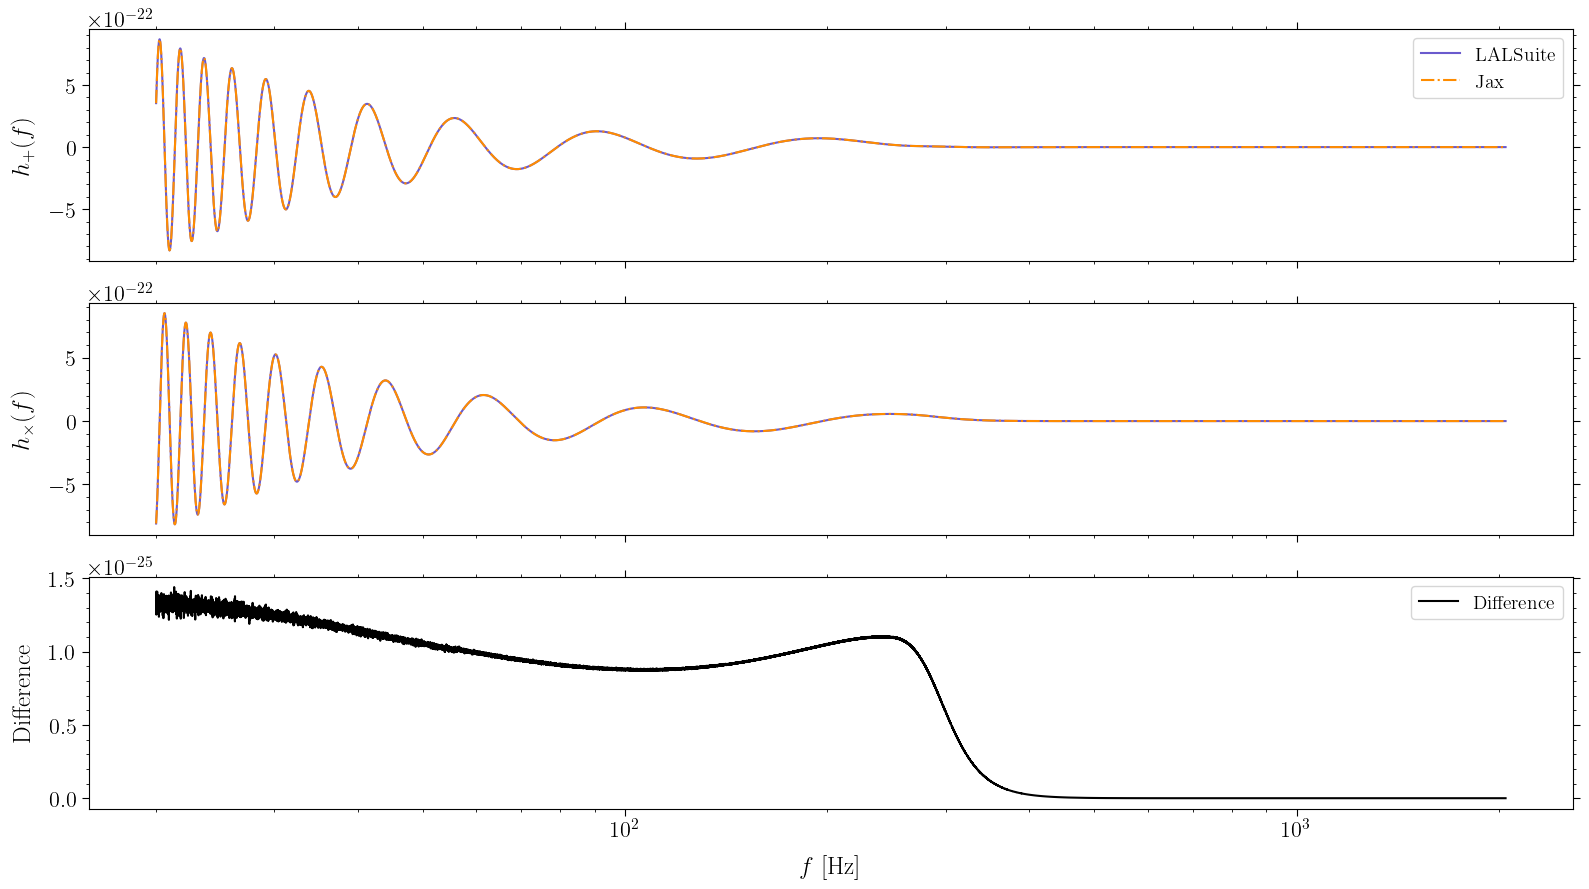

In [7]:
fig, ax = plt.subplots(3, 1, figsize=(16, 9), sharex=True)

ax[0].plot(f, hp_lalsuite.real, label="LALSuite", color="slateblue")
ax[0].plot(f, hp_ripple.real, label="Jax", color="darkorange", linestyle="-.")
ax[0].set_ylabel(r"$h_+ (f)$")
ax[0].set_xscale("log")
ax[0].legend()

ax[1].plot(f, hc_lalsuite.real, label="LALSuite", color="slateblue")
ax[1].plot(f, hc_ripple.real, label="Jax", color="darkorange", linestyle="-.")
ax[1].set_ylabel(r"$h_\times (f)$")

ax[2].plot(f, diff_lal_ripple, label="Difference", color="black")
ax[2].set_ylabel(r"Difference")
ax[2].set_xlabel(r"$f$ [Hz]")
ax[2].legend()

fig.tight_layout()
plt.show()

# **Torch vs LAL**

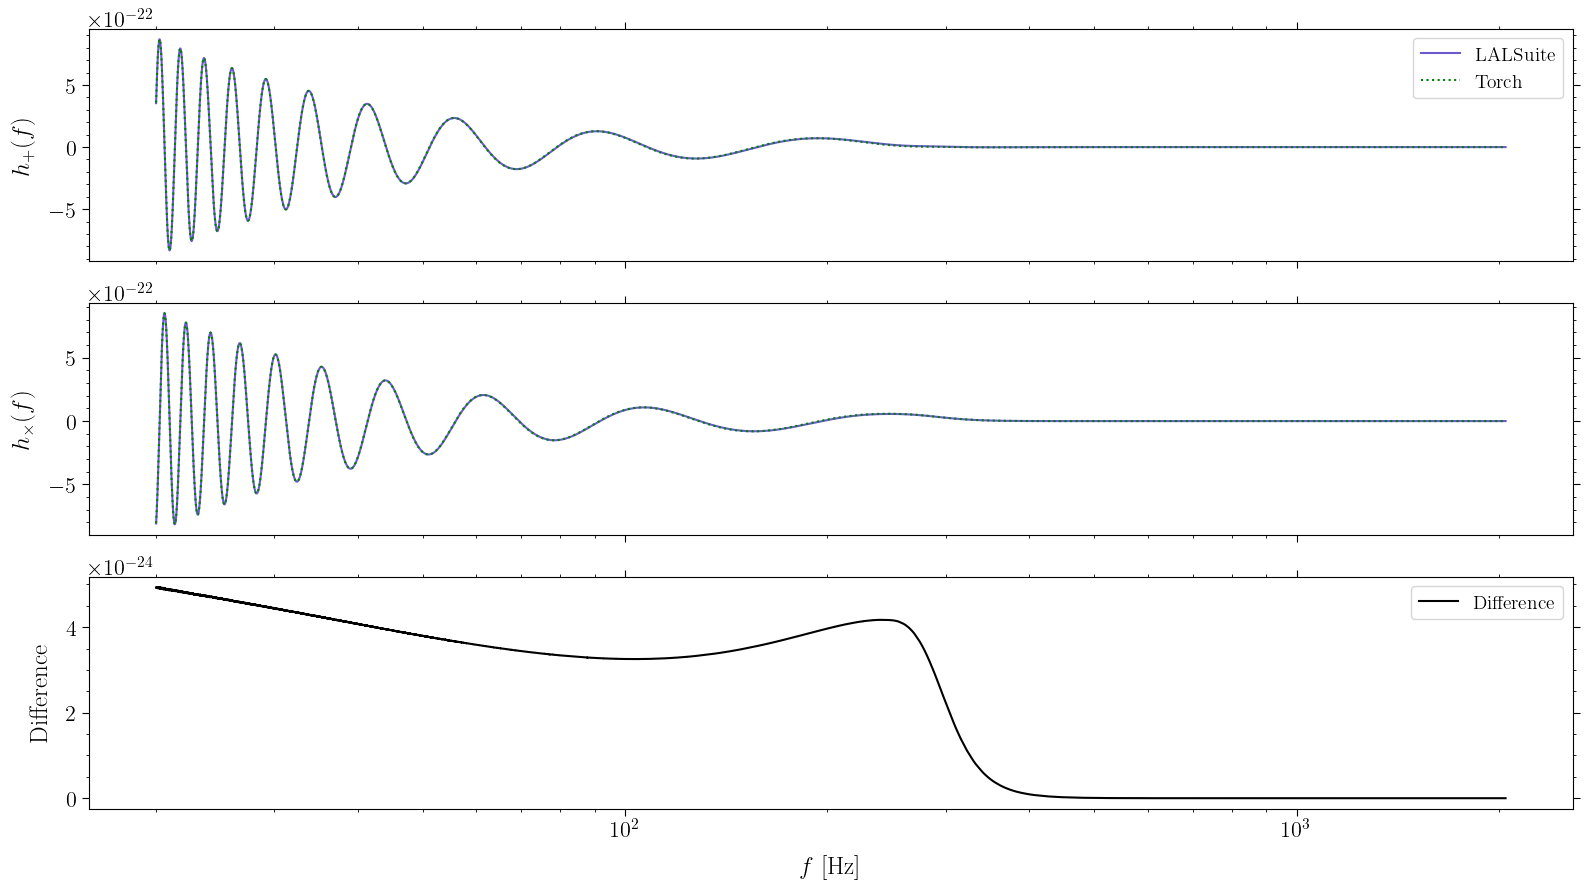

In [8]:
fig, ax = plt.subplots(3, 1, figsize=(16, 9), sharex=True)

ax[0].plot(f, hp_lalsuite.real, label="LALSuite", color="slateblue")
ax[0].plot(f, hp_torch.real, label="Torch", color="green", linestyle=":")
ax[0].set_ylabel(r"$h_+ (f)$")
ax[0].set_xscale("log")
ax[0].legend()

ax[1].plot(f, hc_lalsuite.real, label="LALSuite", color="slateblue")
ax[1].plot(f, hc_torch.real, label="Torch", color="green", linestyle=":")
ax[1].set_ylabel(r"$h_\times (f)$")

ax[2].plot(f, diff_lal_torch, label="Difference", color="black")
ax[2].set_ylabel(r"Difference")
ax[2].set_xlabel(r"$f$ [Hz]")
ax[2].legend()

fig.tight_layout()
plt.show()

# **Torch vs Jax**

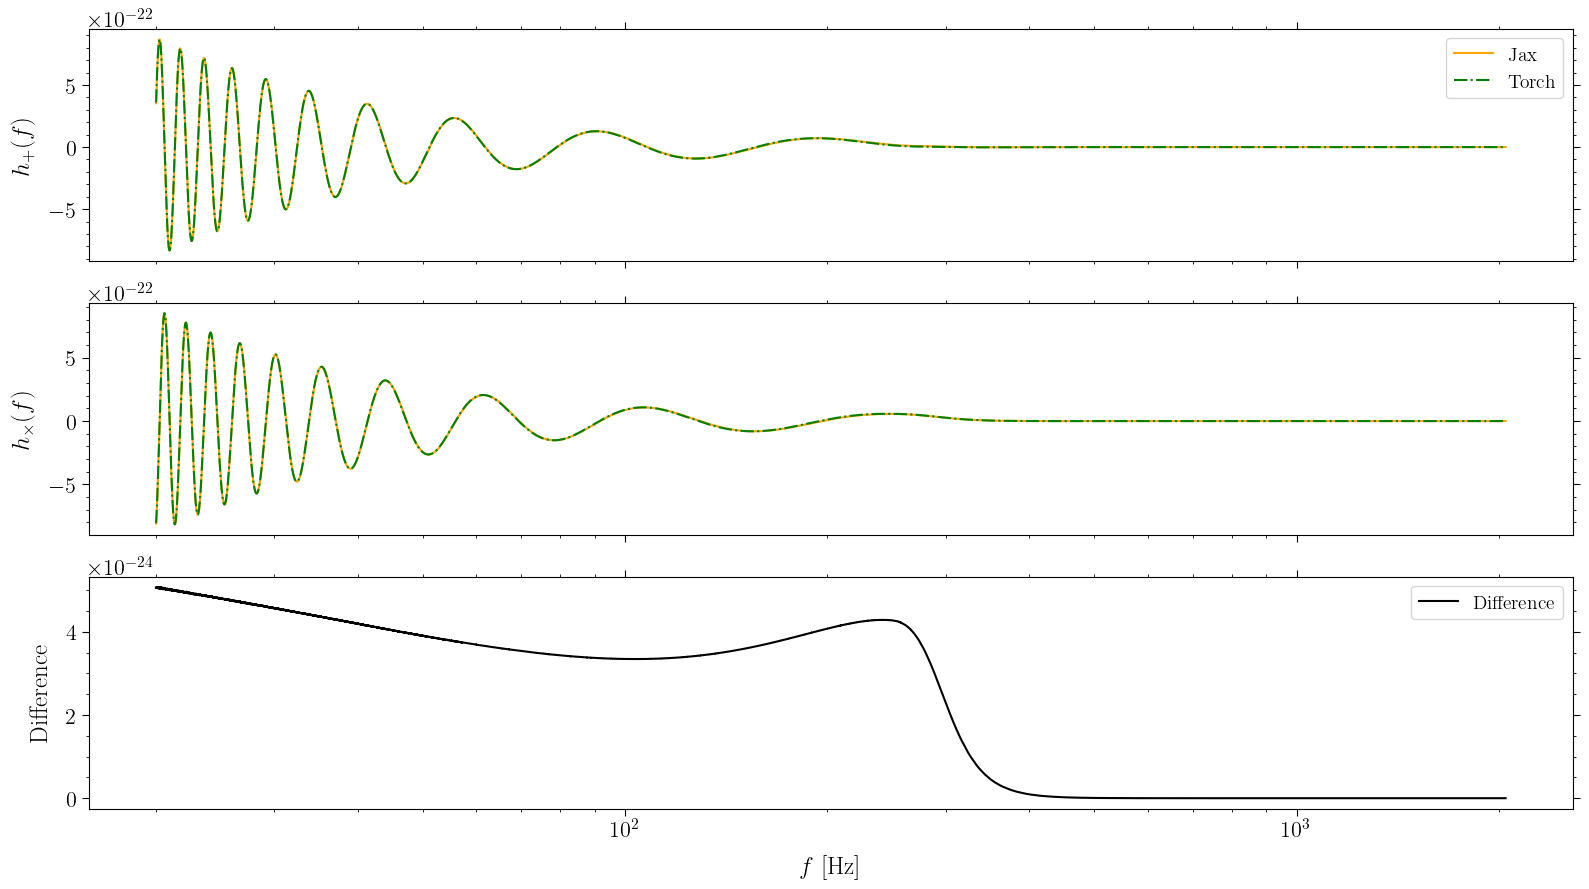

In [9]:
fig, ax = plt.subplots(3, 1, figsize=(16, 9), sharex=True)

ax[0].plot(f, hp_ripple.real, label="Jax", color="orange")
ax[0].plot(f, hp_torch.real, label="Torch", color="green", linestyle="-.")
ax[0].set_ylabel(r"$h_+ (f)$")
ax[0].set_xscale("log")
ax[0].legend()

ax[1].plot(f, hc_ripple.real, label="Jax", color="orange")
ax[1].plot(f, hc_torch.real, label="Torch", color="green", linestyle="-.")
ax[1].set_ylabel(r"$h_\times (f)$")

ax[2].plot(f, diff_ripple_torch, label="Difference", color="black")
ax[2].set_ylabel(r"Difference")
ax[2].set_xlabel(r"$f$ [Hz]")
ax[2].legend()

fig.tight_layout()
plt.show()